# A Basic overview

This tutorial is designed to give users a basic introduction to the core parts of dLux. We will cover how to create an optical system and its psf, how to work with dLux objects, and show a basic optimisation workflow.


## A Simple Optical System

Lets start by constructing a very simple Airy-like optical system, and propagating multiple wavelengths through it.

In [1]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120


In [2]:
# Define our wavefront properties
wf_npix = 512 # Number of pixels in the wavefront
diameter = 1.0 # Diameter of the wavefront, meters

# Construct a simple circular aperture
coords = dlu.pixel_coords(wf_npix, diameter)
aperture = dlu.circle(coords, 0.5*diameter)

# Define our detector properties
psf_npix = 64 # Number of pixels in the PSF
psf_pixel_scale = 50e-3 # 50 mili-arcseconds
oversample = 3 # Oversampling factor for the PSF

# Define the optical layers
# Note here we can pass in a tuple of (key, layer) paris to be able to access the
# layer from the optics object with the key!
layers = [('aperture', dl.layers.TransmissiveLayer(transmission=aperture, normalise=True))]

# Construct the optics object
optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample)

# Models some wavelengths through the system
wavels = 1e-6 * np.linspace(1, 1.2, 10)
psf = optics.propagate(wavels)

# Get out aperture transmission for plotting
# Note we can use the 'aperture' key we supplied in the layers to access that layer
# directly from the optics object!
transmission = optics.aperture.transmission 

# Let examine the optics object! The dLux framework has in-built pretty-printing, so
# we can just print the object to see what it contains.
print(optics)

AngularOpticalSystem(
  wf_npixels=512,
  diameter=1.0,
  layers={
    'aperture':
    TransmissiveLayer(transmission=f32[512,512], normalise=True)
  },
  psf_npixels=64,
  oversample=3,
  psf_pixel_scale=0.05
)


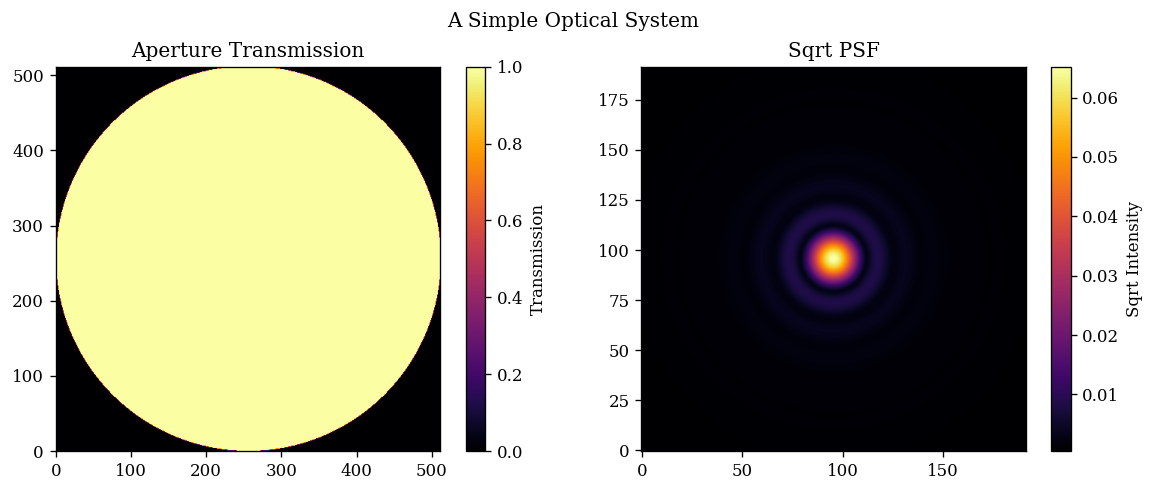

In [3]:
# Plot the results
plt.figure(figsize=(10, 4))
plt.suptitle("A Simple Optical System")
plt.subplot(1, 2, 1)
plt.title("Aperture Transmission")
plt.imshow(transmission)
plt.colorbar(label='Transmission')

plt.subplot(1, 2, 2)
plt.title("Sqrt PSF")
plt.imshow(psf**0.5)
plt.colorbar(label='Sqrt Intensity')
plt.tight_layout()
plt.show()

## Adding Aberrations

It is very common for an optical system to have aberrations that have a significant impact on the psf, so lets see how we can model this!

In [4]:
# First we define the zernike indices we want to model. In this example we ignore the
# even indices, as they suffer from a degeneracy that makes them difficult to recover 
# when we have a symmetric aperture, like a circle!
indices = np.array([2, 3, 7, 8, 9, 10])

# Construct some zernike basis and some coefficients
basis = 1e-9 * dlu.zernike_basis(indices, coords, diameter=diameter)
coefficients = 50 * jr.normal(jr.PRNGKey(0), indices.shape)

# Re-define our layers to include the aberrations
layers = [
    ('aperture', dl.layers.TransmissiveLayer(transmission=aperture, normalise=True)),
    ('aberrations', dl.layers.BasisLayer(basis=basis, coefficients=coefficients))
]

# Re-construct the optics object and re-propagate our wavelengths
optics = dl.AngularOpticalSystem(wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample)
psf = optics.propagate(wavels)

# Get out aperture aberrations for plotting
aberrations = optics.aberrations.eval_basis()

# Print the new object
print(optics)

AngularOpticalSystem(
  wf_npixels=512,
  diameter=1.0,
  layers={
    'aperture':
    TransmissiveLayer(transmission=f32[512,512], normalise=True),
    'aberrations':
    BasisLayer(basis=f32[6,512,512], coefficients=f32[6], as_phase=False)
  },
  psf_npixels=64,
  oversample=3,
  psf_pixel_scale=0.05
)


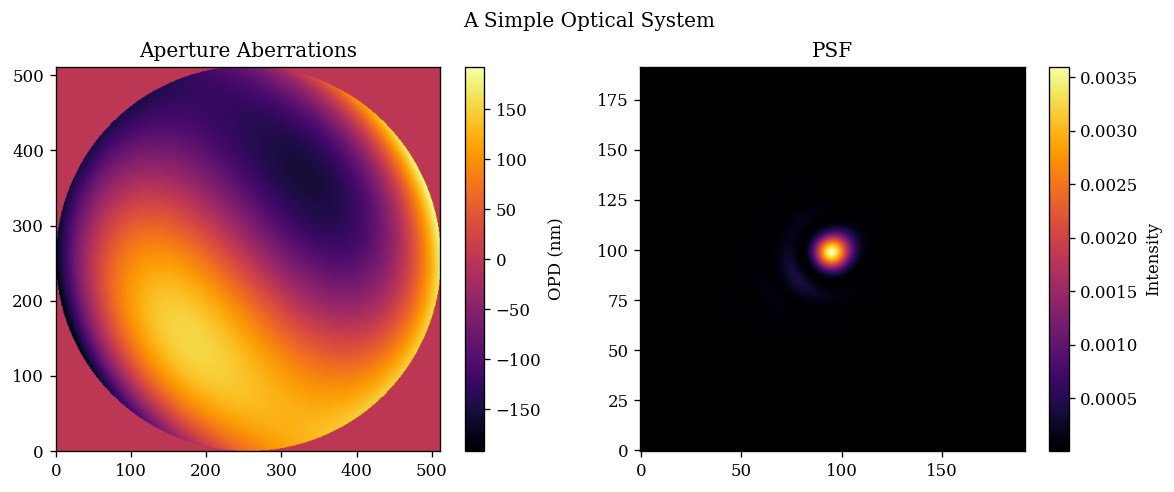

In [5]:
# Plot the results
plt.figure(figsize=(10, 4))
plt.suptitle("A Simple Optical System")
plt.subplot(1, 2, 1)
plt.title("Aperture Aberrations")
plt.imshow(aberrations * 1e9)
plt.colorbar(label='OPD (nm)')

plt.subplot(1, 2, 2)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()

## Working with dLux objects

`dLux` is build within `Zodiax`, which gives all classes a simple path-based way to interact with out objects. We will use this to set update the aberrations in our optical system, and then recover the values from the previous example!

There are two ways we can do this, either by setting the `aberrations.coefficients` values to a new array, or multiplying the current value by zero. We will show how to do both of these.

Note that we will call the new object `model` since we will use this object to try and recover the initial values we set.

In [6]:
# Define our new coefficients and update the optics object
new_coefficients = np.zeros(coefficients.shape)
model = optics.set('aberrations.coefficients', new_coefficients)

# Multiply the existing coefficients by zero
model = optics.multiply('aberrations.coefficients', 0.0)

# New we can re-propagate our wavelengths to check that we have an un-aberrated PSF
psf = model.propagate(wavels)

# Extract out values for plotting
aberrations = model.aberrations.eval_basis()

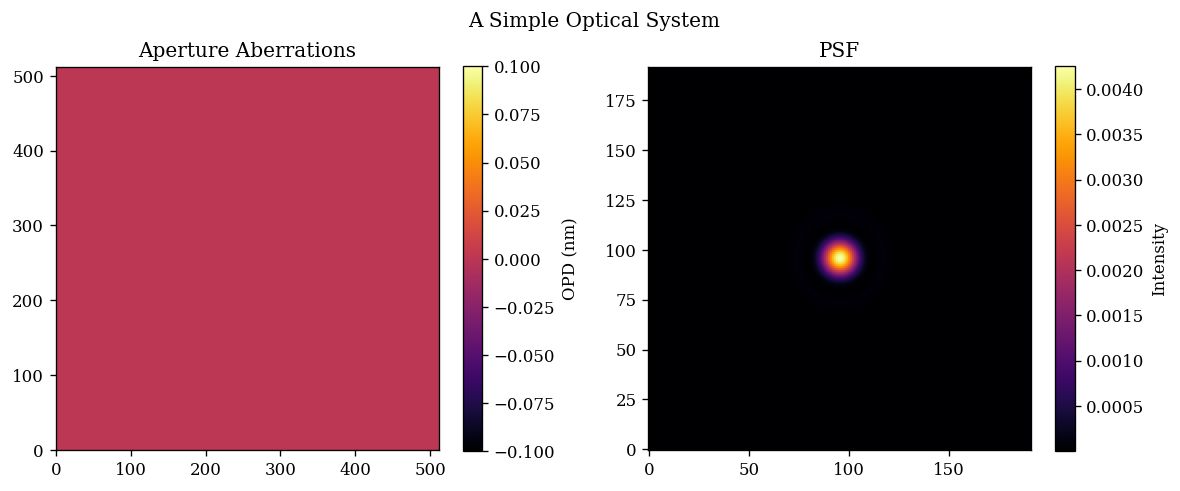

In [7]:
# Plot the results
plt.figure(figsize=(10, 4))
plt.suptitle("A Simple Optical System")
plt.subplot(1, 2, 1)
plt.title("Aperture Aberrations")
plt.imshow(aberrations * 1e9)
plt.colorbar(label='OPD (nm)')

plt.subplot(1, 2, 2)
plt.title("PSF")
plt.imshow(psf)
plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()

## Taking Gradients

One of primary benefits of dLux is it is _differentiable_, meaning we can use autodiff to take gradients of any parameter in out model with respect to an arbitrary loss function.

To do this we will use `Zodiax`, which allows us to take gradients with respect to _specific_ parameters in our model, with a path-based interface. 

In [8]:
# Generate some data to take gradients with respect to
flux = 1e4
data = jr.poisson(jr.PRNGKey(1), flux * optics.propagate(wavels))

# Define out loss function, in this case a simple poisson log-likelihood
@zdx.filter_value_and_grad('aberrations.coefficients')
def loss_fn(model, data):
    psf = flux * model.propagate(wavels)
    return - jsp.stats.poisson.logpmf(data, psf).mean()

# Now we evaluate the loss function and get the gradients
loss, grads = loss_fn(model, data)

# Note that Zodiax will return the gradients in the same structure as the model, ie, 
# an optics object! This means we can use all the same methods to examine values as we
# would the normal optics object, so lets have a look.
print(f"Loss: {loss}\n")
print(f"Coefficient gradients: {grads.aberrations.coefficients}\n")
print(f"Gradients object: {grads}")

Loss: 0.288269966840744

Coefficient gradients: [ 3.8819111e-05  1.4264378e-03 -6.6455011e-04 -1.2623395e-03
 -2.2182279e-04 -1.6320724e-05]

Gradients object: AngularOpticalSystem(
  wf_npixels=None,
  diameter=None,
  layers={
    'aperture':
    TransmissiveLayer(transmission=None, normalise=None),
    'aberrations':
    BasisLayer(basis=None, coefficients=f32[6], as_phase=None)
  },
  psf_npixels=None,
  oversample=None,
  psf_pixel_scale=None
)


## Compiling and Optimisation

Working within the `jax` framework allows us to compile our code to XLA, which can significantly speed up the execution of our code. Lets do this and see how fast out model is able to evaluate! `Zodiax` provides a simple interface that allows us to compile our _whole object_ to XLA using `zdx.filter_jit`, which is very convenient.

In [9]:
# First we start by jit-compiling our loss function
jit_loss = zdx.filter_jit(loss_fn)

# Now lets have a look at the performance of the loss function
# Note we need to use the block_until_ready() method to ensure the computation is
# timed correctly, this is because jax uses asynchronous computation by default.
time_regular = %timeit -o loss_fn(model, data)[0].block_until_ready()
time_jit = %timeit -o jit_loss(model, data)[0].block_until_ready()

# Display timing results
print(f"Regular time: {time_regular.average*1e3:.5} ms")
print(f"Jit time: {time_jit.average*1e3:.5} ms")
print(f"Improvement: {time_regular.average/time_jit.average:.3}x faster")

126 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
86.1 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Regular time: 126.33 ms
Jit time: 86.124 ms
Improvement: 1.47x faster


Excellent, now that we have our compile loss function, lets optimise our model!

To do this we use `optax`, the gradient processing library developed by Googles DeepMind team. This library provides a number of optimisation algorithms, and we will use the `adam` optimiser here. `Zodiax` also provides a simple way to map our optimisation algorithms to our model, using `zdx.get_optimiser` function.

In [10]:
# Construct our optimiser objects
optim, opt_state = zdx.get_optimiser(model, 'aberrations.coefficients', optax.adam(1e1))

# Set up a progress bar
pbar = tqdm(range(50), desc="Loss: ")

# A basic optimisation loop
losses, models = [], []
for i in pbar: 

    # Calculate the loss gradients, and update the model
    loss, grads = jit_loss(model, data) 
    updates, opt_state = optim.update(grads, opt_state)
    model = zdx.apply_updates(model, updates)
    
    # save results
    models.append(model) 
    losses.append(loss)
    
    pbar.set_description('Loss %.5f' % (loss)) # update the progress bar

Loss:   0%|          | 0/50 [00:00<?, ?it/s]

Now we visualise the results of our optimisation!

/var/folders/28/6s47s91d14ldjdrljs4d1hxw0000gn/T/ipykernel_99309/221892161.py:44: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


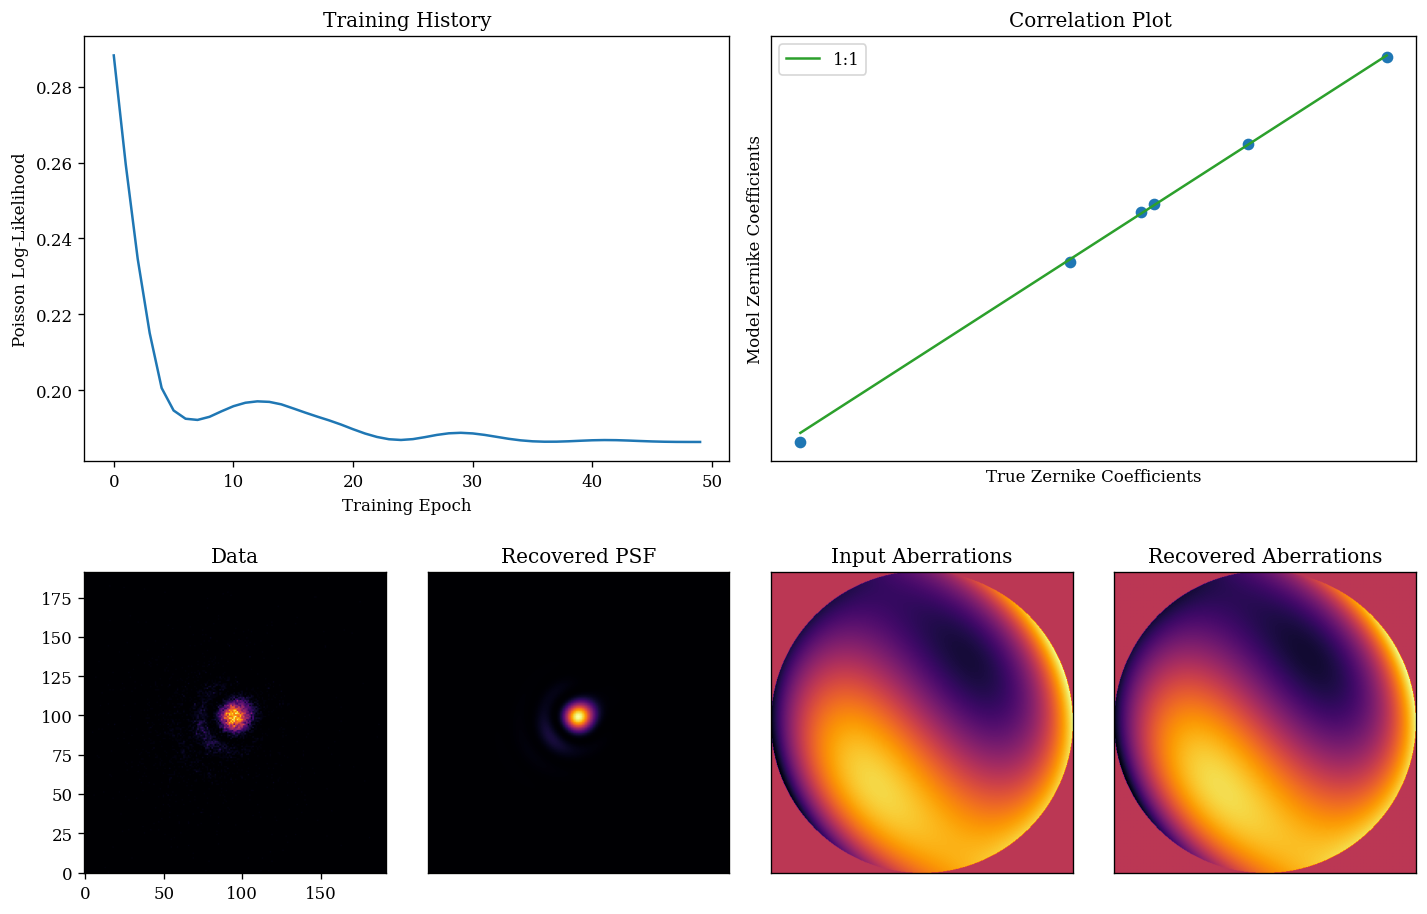

In [11]:
psf = model.propagate(wavels)
coeffs_found = np.array([m.get('aberrations.coefficients') for m in models])
true_opd = optics.aberrations.eval_basis()
found_opd = model.aberrations.eval_basis()

mosaic = """
    AABB
    CDEF
    """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['B','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])

axes['A'].plot(np.array(losses))
axes['A'].set_title("Training History")
axes['A'].set_xlabel('Training Epoch')
axes['A'].set_ylabel('Poisson Log-Likelihood')

axes['B'].plot(coefficients, coeffs_found[-1],'.', markersize=12)
axes['B'].plot(np.array([np.min(coefficients),np.max(coefficients)]),
               np.array([np.min(coefficients),np.max(coefficients)]),
               '-',color='C2',label='1:1')
axes['B'].legend()
axes['B'].set_title('Correlation Plot ')
axes['B'].set_xlabel('True Zernike Coefficients')
axes['B'].set_ylabel('Model Zernike Coefficients')

axes['C'].imshow(data)
axes['C'].set_title('Data')

axes['D'].imshow(psf)
axes['D'].set_title('Recovered PSF')

axes['E'].imshow(true_opd)
axes['E'].set_title('Input Aberrations')

axes['F'].imshow(found_opd)
axes['F'].set_title('Recovered Aberrations')

fig.tight_layout()
# fig.savefig("assets")
# plt.show()

There we go! We have successfully optimised our model to recover the initial values we set. This is a very simple example, but it shows the basic workflow of how to use dLux to optimise an optical system.